In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, roc_curve, roc_auc_score, plot_precision_recall_curve, classification_report, accuracy_score,confusion_matrix,ConfusionMatrixDisplay
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.ensemble import IsolationForest

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("diabetes_binary_5050split_health_indicators_BRFSS2015.csv")
print(df.isna().sum())

Diabetes_binary         0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64


***
Checked the dataset to see if there is a null value<br>
**No null value**
***

In [3]:
print(df.duplicated().sum())
df.drop_duplicates(inplace=True)

1635


***
Checked the dataset to count duplicates and eliminate them<br>
**Eliminated 1635 duplicate observations**
***

In [4]:

model = IsolationForest()
model.fit(df)

df['anomaly']= model.predict(df)
df.drop(df[df['anomaly']==-1].index,inplace = True)
df.drop(columns=['anomaly'], inplace=True)

df = df.sample(frac = 1)
df.reset_index(inplace=True)
df.drop(columns="index",inplace=True)

dfSubData = df.loc[:3000]

***
I used IsolationForest algorithm to see anomalies in the data and dropped observations with anomalies<br>
And then created a subData from data in a random manner to preserve datas unique distribution as much as I can<br>
Since working with ~40k observations is time/power consuming I trimmed data to have 3000 observations
***

In [5]:
dfSubData.loc[dfSubData["BMI"]<18.5,"BMI"] =0 
#Underweight
dfSubData.loc[(dfSubData["BMI"]>=18.5)&(dfSubData["BMI"]<25),"BMI"] =1
#Normal
dfSubData.loc[(dfSubData["BMI"]>=25)&(dfSubData["BMI"]<30),"BMI"] =2
#Overweight
dfSubData.loc[(dfSubData["BMI"]>=30)&(dfSubData["BMI"]<35),"BMI"] =3
#Obese
dfSubData.loc[(dfSubData["BMI"]>=35),"BMI"] =4
#Extremely Obese

***
Since BMI can be replaced with corresponding body types and it will be more meaningful, I replaced them  
***

In [6]:
dfSubData = pd.read_csv("diabetes_binary_trimmed.csv")


***
**FROM NOW ON I WILL USE THE DATASET I HAVE TRIMMED AND PREPROCESSED BEFORE TO PREVENT SURPRISES WITH UNSEEN DATA**<br>
All this preprocessing happened as you've seen so far
***

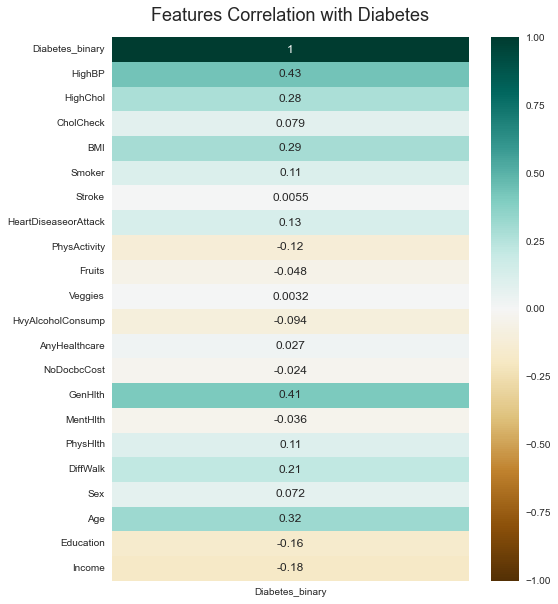

In [7]:
corr = dfSubData.corr()
plt.figure(figsize=(8, 10))
heatmap = sns.heatmap(dfSubData.corr()[['Diabetes_binary']], vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlation with Diabetes', fontdict={'fontsize':18}, pad=16)
plt.show()

***
Just to illustrate correlation between each column, no need to drop low correlated ones. Our models will take care of them
***

In [8]:
"""
f=plt.figure(figsize=(10,10))
for i, col in enumerate(dfSubData.columns):
    ax=f.add_subplot(7,4,i+1)
    sns.distplot(dfSubData[col].ffill(),kde=False)
    ax.set_title(col+" Distribution",color='Blue')
    plt.ylabel('Distribution')
f.tight_layout()

f=plt.figure(figsize=(10,10))
for i, col in enumerate(df.columns):
    ax=f.add_subplot(7,4,i+1)
    sns.distplot(df[col].ffill(),kde=False)
    ax.set_title(col+" Distribution",color='Blue')
    plt.ylabel('Distribution')
f.tight_layout()
"""

'\nf=plt.figure(figsize=(10,10))\nfor i, col in enumerate(dfSubData.columns):\n    ax=f.add_subplot(7,4,i+1)\n    sns.distplot(dfSubData[col].ffill(),kde=False)\n    ax.set_title(col+" Distribution",color=\'Blue\')\n    plt.ylabel(\'Distribution\')\nf.tight_layout()\n\nf=plt.figure(figsize=(10,10))\nfor i, col in enumerate(df.columns):\n    ax=f.add_subplot(7,4,i+1)\n    sns.distplot(df[col].ffill(),kde=False)\n    ax.set_title(col+" Distribution",color=\'Blue\')\n    plt.ylabel(\'Distribution\')\nf.tight_layout()\n'

**Distribution of Subdata**&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;**Distribution of Data**<br>
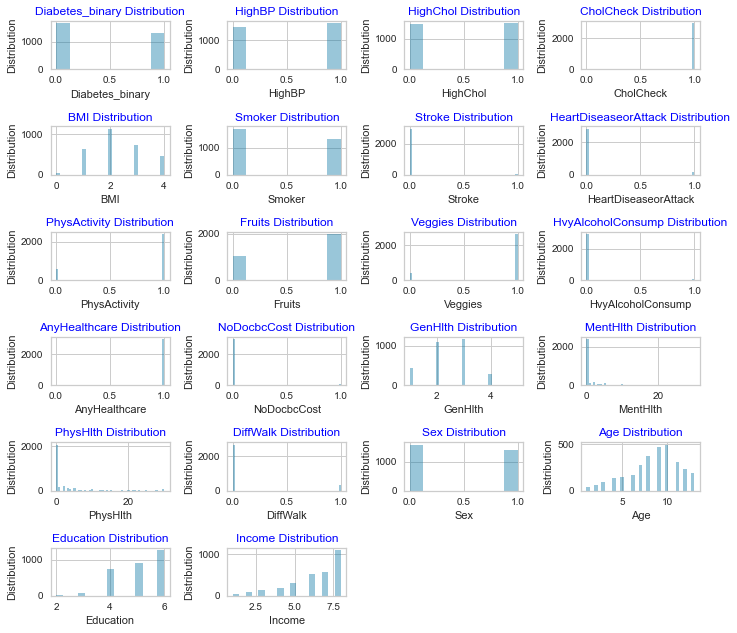
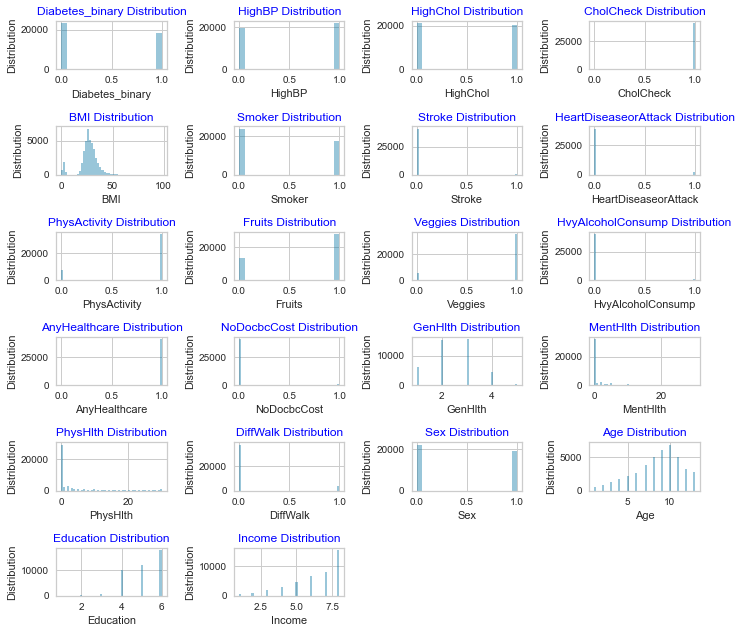

***
**As we can see from distributions, Subdata and Data has the same distribution. Hence we can use the SubData**  
***

In [9]:
for i in range(2,8):
    kMeansCluster = KMeans(n_clusters=i)
    kMeansPredict  = kMeansCluster.fit_predict(dfSubData)
    score = silhouette_score(dfSubData,kMeansPredict,metric="euclidean")
    print("For n_clusters = {}, silhoutte score is {}".format(i,score))



For n_clusters = 2, silhoutte score is 0.6672153410219956
For n_clusters = 3, silhoutte score is 0.5916136210266457
For n_clusters = 4, silhoutte score is 0.24680752883457413
For n_clusters = 5, silhoutte score is 0.28404341743278905
For n_clusters = 6, silhoutte score is 0.2881106357577342
For n_clusters = 7, silhoutte score is 0.22350077683105474


***
**Silhoutte score analysis for clustering analysis**
***

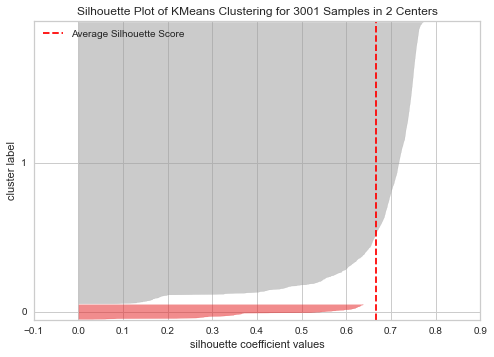

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 3001 Samples in 2 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [10]:
# Instantiate the clustering model and visualizer
km = KMeans (n_clusters=2)
#Since silhoutte score for clusters = 2 is the optimum, we used n_clusters = 2
visualizer = SilhouetteVisualizer(km)

visualizer.fit(dfSubData) # Fit the training data to the visualizer
visualizer.poof() # Draw/show/poof the data

In [11]:
kMeans = KMeans(n_clusters=2)
kMeans.fit(dfSubData)
km_labels = kMeans.labels_
dfSubData["kMeansLabels"] = km_labels

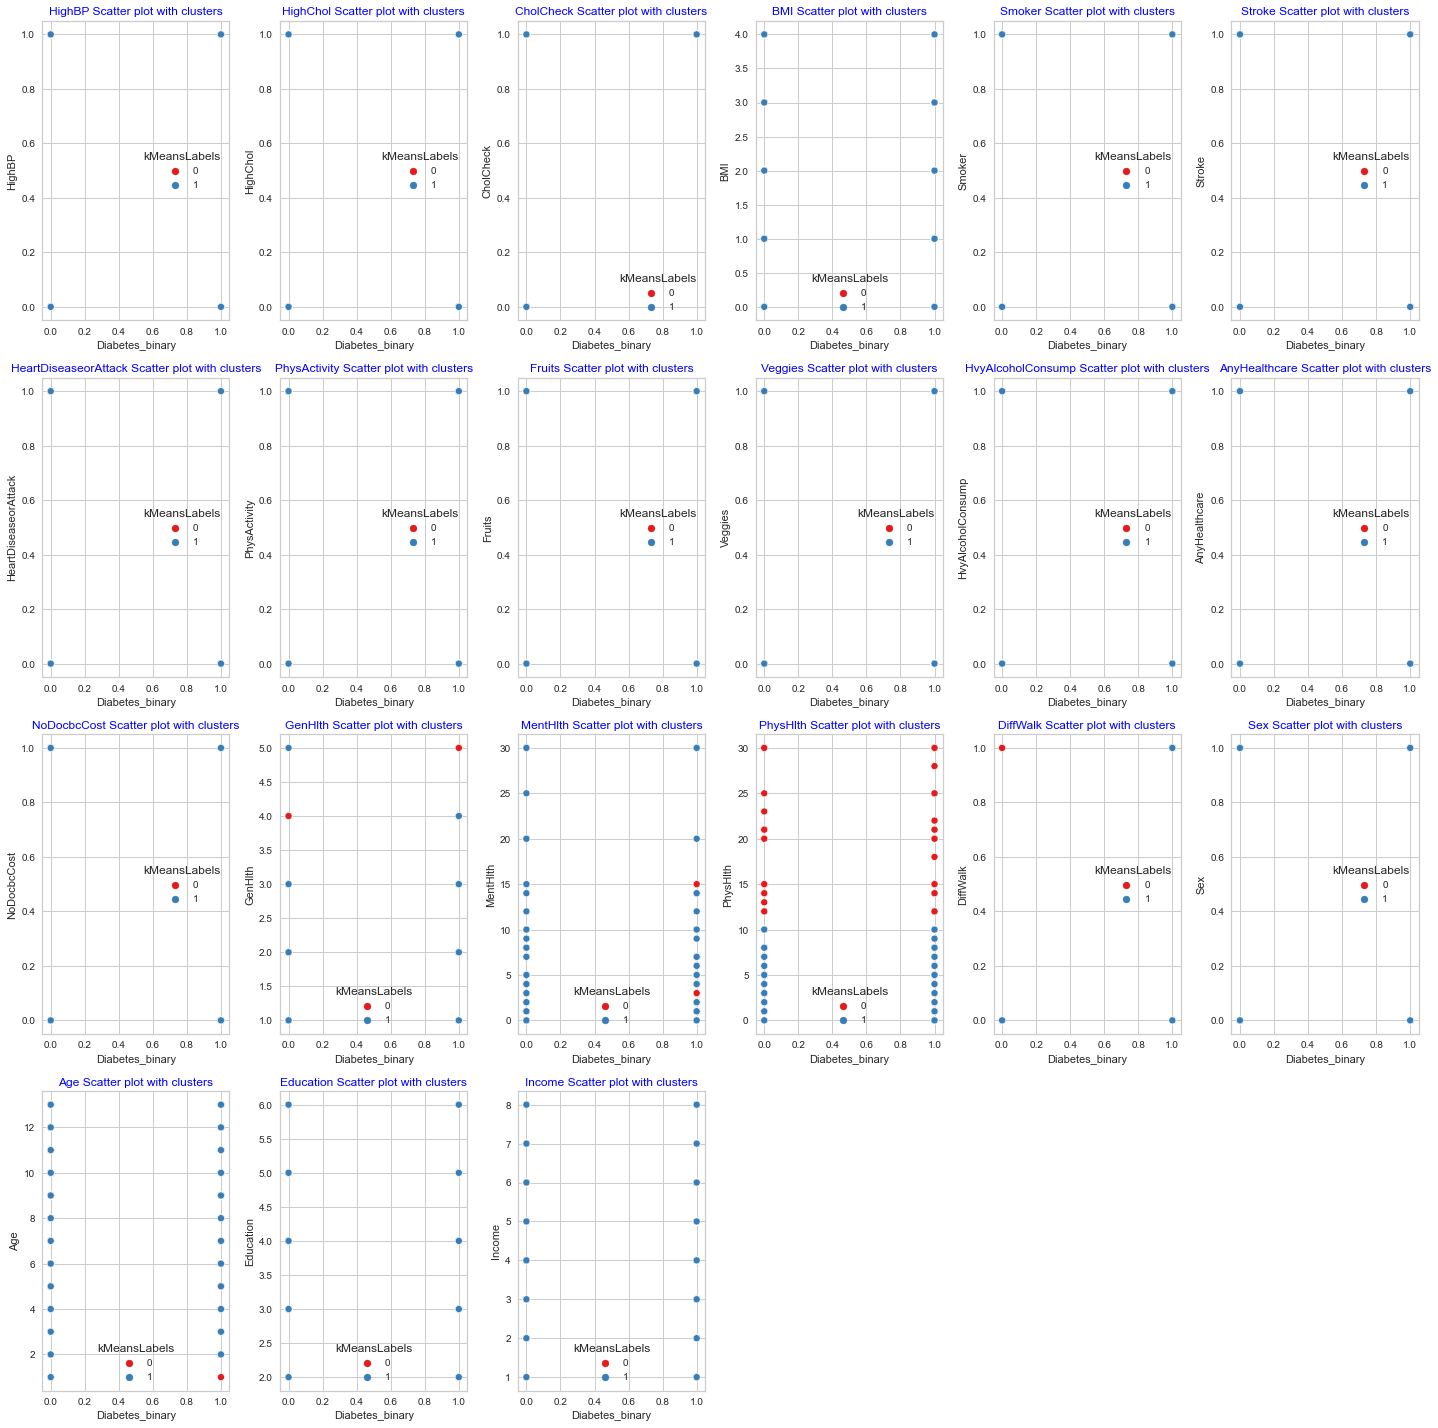

In [12]:
f=plt.figure(figsize=(20,20))
scatter_cols =['HighBP','HighChol','CholCheck','BMI','Smoker','Stroke','HeartDiseaseorAttack',
    'PhysActivity','Fruits','Veggies','HvyAlcoholConsump','AnyHealthcare','NoDocbcCost',
    'GenHlth','MentHlth','PhysHlth','DiffWalk','Sex','Age','Education','Income']
for i, col in enumerate(scatter_cols):
    ax=f.add_subplot(4,6,i+1)
    sns.scatterplot(x=dfSubData['Diabetes_binary'],y=dfSubData[col],hue=dfSubData['kMeansLabels'],palette='Set1')
    ax.set_title(col+" Scatter plot with clusters",color='blue')
    plt.ylabel(col)
f.tight_layout()

***
**Because the data has normalized before, clustering analysis is not so explanatory**
***

In [13]:
dfSubData.drop(columns="kMeansLabels",inplace=True)
dfSubData = dfSubData.sample(frac = 1)
#Shuffled the data set

seventyPer = int(dfSubData.shape[0]/10*7)

#Splitting the train data
train_data = dfSubData.iloc[:seventyPer,:]
x_train = train_data.drop(columns="Diabetes_binary")
y_train = train_data["Diabetes_binary"]

#Splitting the test data
test_data = dfSubData.iloc[seventyPer:,:]
x_test = test_data.drop(columns="Diabetes_binary")
y_test = test_data["Diabetes_binary"]

In [14]:
def visualize(model):
    global x_test,y_test,x_train,y_train

    modelPredictions = model.predict(x_test)
    #Hold predictions of the model

    scores = cross_val_score(model, x_train, y_train, cv=10)
    #Do a 10-Fold Cross Validation
    print("10-Fold Cross  Validaton Score is: ",scores.mean())

    #Confusion matrix
    cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test,modelPredictions), display_labels = [False, True])
    cm_display.plot()
    plt.grid(False)
    plt.show()

    #ROC CURVE     
    ns_probs = [0 for _ in range(len(y_test))]
    model_probs = model.predict_proba(x_test)
    # keep probabilities for the positive outcome only
    model_probs = model_probs[:, 1]
    # calculate scores
    ns_auc = roc_auc_score(y_test, ns_probs)
    model_auc = roc_auc_score(y_test, model_probs)
    # summarize scores
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Model: ROC AUC=%.3f' % (model_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    model_fpr, model_tpr, _ = roc_curve(y_test, model_probs)
    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(model_fpr, model_tpr, marker='.', label='Model')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

    #PR CURVE
    plot_precision_recall_curve(model,x_test,y_test)


# 1. KNeighborsClassifier

Minimum error:- 0.27081021087680357 at K = 37


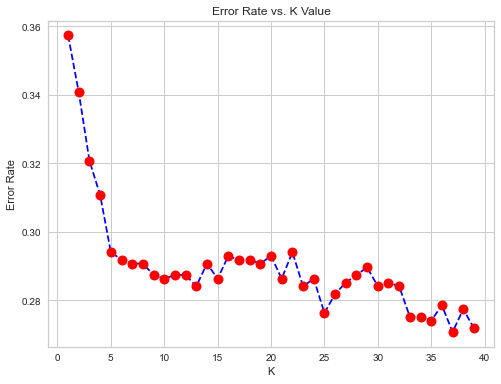

In [15]:
error_rate = []
for i in range(1,40):
    #For k values from 1 to 40 
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_train,y_train)
    #Fit the data to model
    pred_i = knn.predict(x_test)
    #Hold predictions for n_neighbors=i
    error_rate.append(np.mean(pred_i != y_test))
    #Append error rate list
    
plt.figure(figsize=(8,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
optimal_k = error_rate.index(min(error_rate))+1
print("Minimum error:-",min(error_rate),"at K =",optimal_k)
#Plot the k-Error rate function to get optimal k value with elbow function

10-Fold Cross  Validaton Score is:  0.7223809523809523


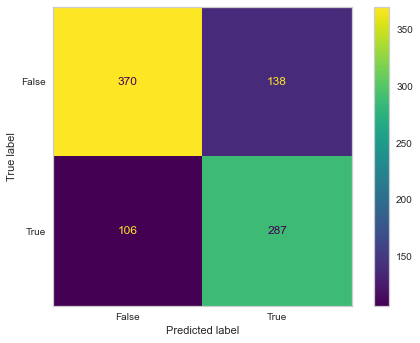

No Skill: ROC AUC=0.500
Model: ROC AUC=0.806


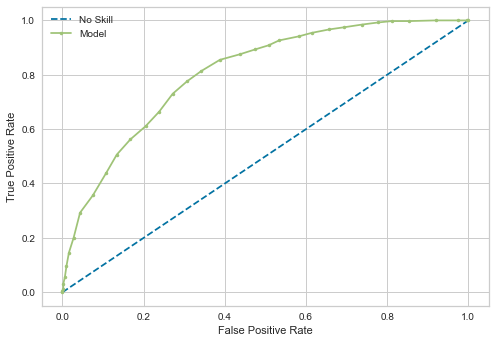

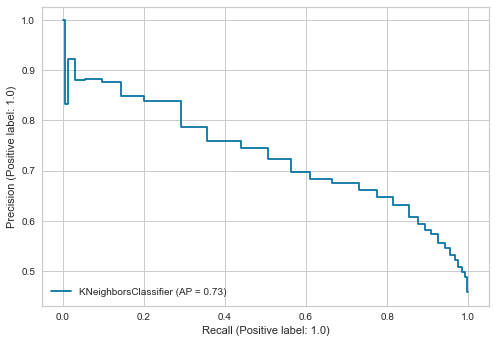

In [16]:
knn = KNeighborsClassifier(n_neighbors=optimal_k)
knn.fit(x_train,y_train)

visualize(knn)

# 2. LogisticRegression

10-Fold Cross  Validaton Score is:  0.7538095238095238


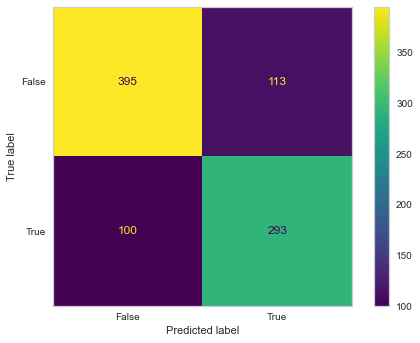

No Skill: ROC AUC=0.500
Model: ROC AUC=0.842


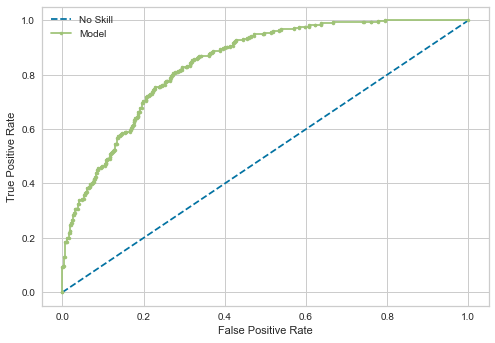

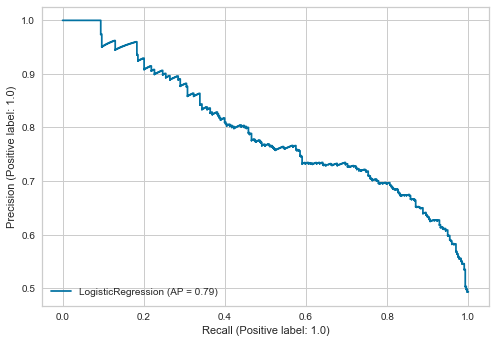

In [17]:
lr = LogisticRegression()

lr.fit(x_train, y_train)
visualize(lr)


# 3. DecisionTreeClassifier(Without pruning)

10-Fold Cross  Validaton Score is:  0.6676190476190477


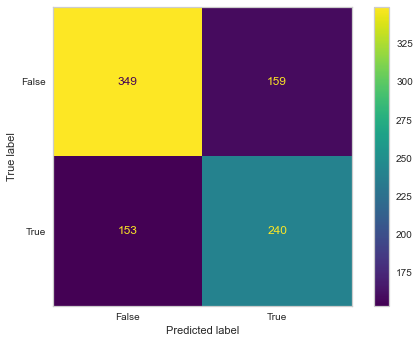

No Skill: ROC AUC=0.500
Model: ROC AUC=0.647


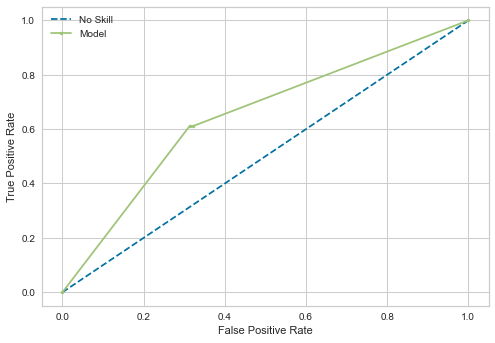

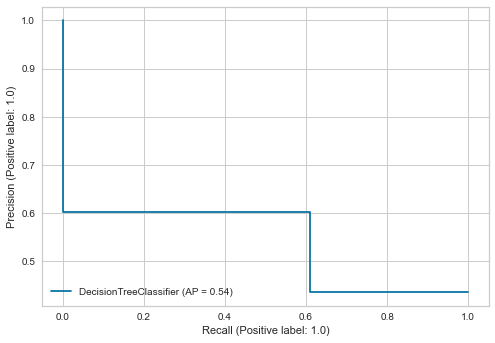

In [18]:
dTree = DecisionTreeClassifier()
dTree.fit(x_train,y_train)    
visualize(dTree)

***
**As we can predict, training DecisionTree without setting any boundaries lead to overfitting in data. Which decreases the accuracy of model**
***

# 4. DecisionTreeClassifier(With pre-pruning)

In [19]:

dTree = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator=dTree, param_grid={'max_depth' : [3,4,5,6,7,8,9,10,11],'max_features':[2,4,6,8,10,12,14,16,18]})
grid_search.fit(x_train, y_train)
print('Best max_depth:', grid_search.best_estimator_.get_params()['max_depth'])

Best max_depth: 5


10-Fold Cross  Validaton Score is:  0.7347619047619048


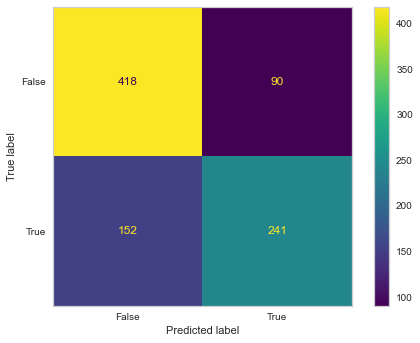

No Skill: ROC AUC=0.500
Model: ROC AUC=0.805


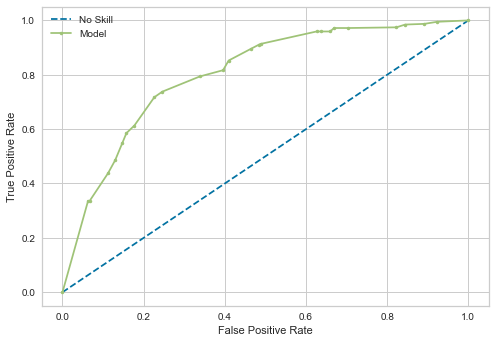

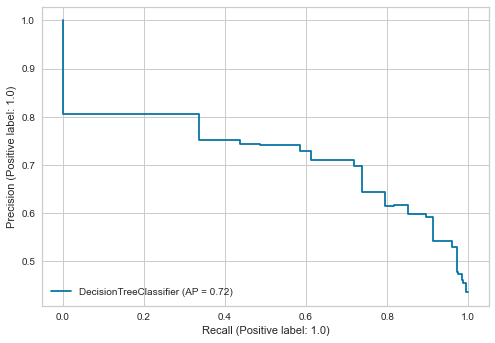

In [20]:
dTree = DecisionTreeClassifier(criterion="gini",max_depth=grid_search.best_estimator_.get_params()['max_depth'])
dTree.fit(x_train,y_train)
dTree_predicts = dTree.predict(x_test)

visualize(dTree)

***
**As we can see, pre-pruning DecisionTree algorithm yields us %10 more accurate predictions**
***